In [1]:
import os
import sys

if os.path.abspath('../src') not in sys.path:
    sys.path.append(os.path.abspath('../src'))

import time
from pathlib import Path

import pandas as pd
from datasets import load_dataset
from multiprocess import set_start_method
from tqdm.auto import tqdm

from interface import MolRSmilesEmbedder

try:
    set_start_method("spawn")
except RuntimeError as e:
    print(e)

from datasets import disable_caching

disable_caching()

/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = Path('../saved/tag_1024')
DATA_PATH = Path("../../data/CS2/all.csv")  # Path to the dataset

embedder = MolRSmilesEmbedder(MODEL_PATH)
dataset = load_dataset('csv', data_files=str(DATA_PATH), split='train')
emb_dataset = dataset.select(range(10000)).map(embedder, batched=True, batch_size=256, num_proc=4)
dimension = len(emb_dataset[0]['vector'])
print(f"embedding dimension: {dimension}")

Map (num_proc=4): 100%|██████████| 10000/10000 [00:19<00:00, 526.17 examples/s] 


embedding dimension: 1024


In [4]:
def time_vs_batch_size_datasets(embedding_processor, dataset, batch_sizes = [1024]):
    times = []
    for batch_size in tqdm(batch_sizes, leave=False, position=0):
        start = time.time()
        _ = dataset.map(
            embedding_processor,
            batched=True,
            batch_size=batch_size,
            with_rank=True,
            num_proc=4,
            )
        end = time.time()
        times.append(end - start)
    res = pd.DataFrame({'batch_size': batch_sizes, 'time': times})
    res['time_per_mol'] = res['time'] / len(dataset)
    return res

In [6]:
results = time_vs_batch_size_datasets(embedder, dataset.select(range(10000)), batch_sizes=[8, 16, 32, 64, 128, 256, 512, 1024, 2048])

  0%|          | 0/9 [00:00<?, ?it/s]

Map (num_proc=4): 100%|██████████| 10000/10000 [00:20<00:00, 497.90 examples/s]


<Axes: xlabel='batch_size'>

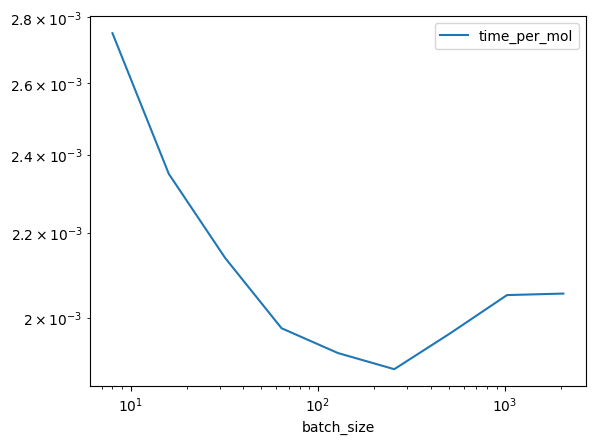

In [7]:
results.plot(x='batch_size', y='time_per_mol', logx=True, logy=True)

In [8]:
def convert_all(embedder, cs_numbers = [1, 2, 3, 5, 6, 7, 8]):
    for ii, cs_number in enumerate(cs_numbers):
        print(f"Converting CS{cs_number}, {ii+1}/{len(cs_numbers)}")
        DATA_PATH = Path(f"../../data/CS{cs_number}/all.csv")  # Path to the dataset
        dataset = load_dataset('csv', data_files=str(DATA_PATH), split='train')
        emb_dataset = dataset.map(embedder, batched=True, batch_size=256, num_proc=4)
        emb_dataset.save_to_disk(DATA_PATH.parent / 'all_embeddings')

In [9]:
convert_all(embedder, [2, 3, 5, 6, 7, 8])

Converting CS1, 1/7


Saving the dataset (11/11 shards): 100%|██████████| 1026538/1026538 [00:34<00:00, 29965.21 examples/s]


Converting CS2, 2/7


Map (num_proc=4):   0%|          | 1024/1026538 [00:10<2:49:33, 100.80 examples/s]


TimeoutError: 